<a href="https://colab.research.google.com/github/shekharkhandelwal1983/DLforDataArchitects/blob/main/notebooks/chapter9/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]


11490434/11490434 [==============================] - 0s 0us/step


In [3]:
def make_generator_model():
    model = Sequential()

    # Dense layer
    model.add(Dense(256 * 7 * 7, input_shape=(100,), use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Reshape layer
    model.add(Reshape((7, 7, 256)))

    # Convolutional Transpose layers
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Output layer
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()


In [4]:
def make_discriminator_model():
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    # Flatten layer
    model.add(Flatten())

    # Output layer
    model.add(Dense(1))

    return model

discriminator = make_discriminator_model()


In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)


In [6]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


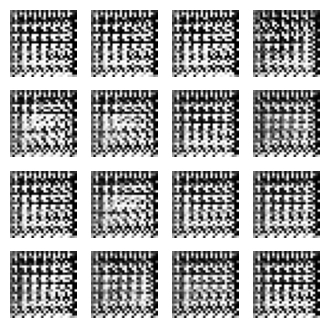

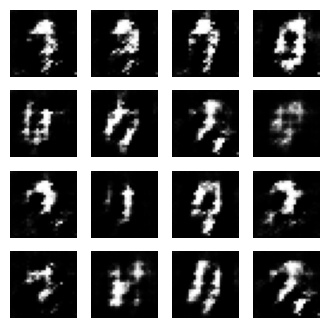

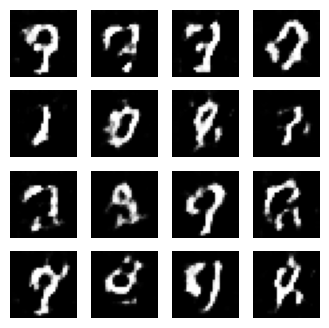

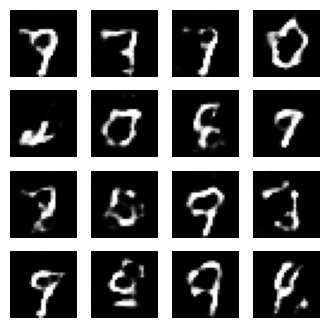

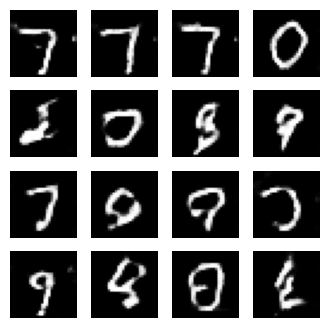

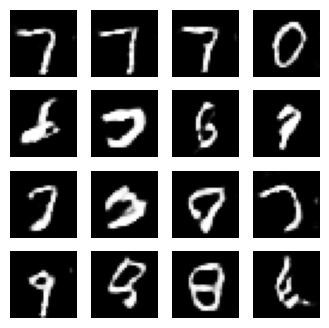

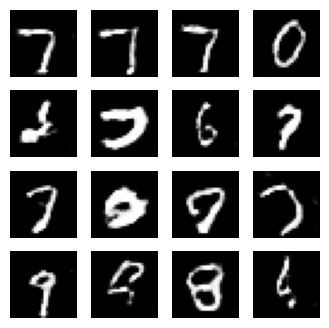

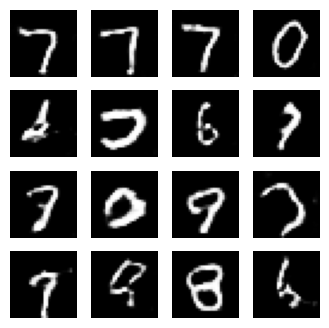

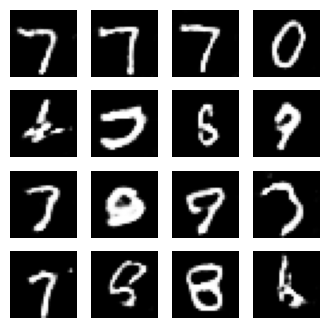

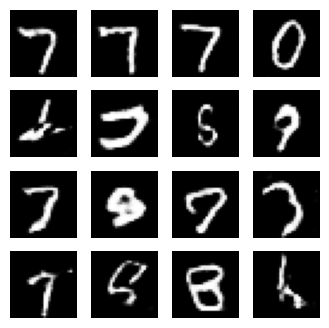

In [7]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) * 127.5
    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

epochs = 50
noise_dim = 100
num_examples_to_generate = 16
random_vector_for_generation = tf.random.normal([num_examples_to_generate, noise_dim])
batch_size = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images.reshape(train_images.shape[0], 28, 28, 1)).shuffle(60000).batch(batch_size)

# Training Loop
for epoch in range(epochs):
    for images in train_dataset:
        train_step(images)

    # Generate and save images
    if (epoch + 1) % 5 == 0:
        generate_and_save_images(generator, epoch + 1, random_vector_for_generation)


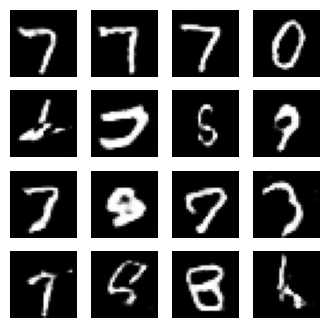

In [8]:
# Display the final epoch's image
generate_and_save_images(generator, epochs, random_vector_for_generation)
